In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xyStripTools

from xyStripTools import random_three_vector
from xyStripTools import plot_track
from xyStripTools import T_off


In [2]:
# Specify solid angle range in theta [degrees]
# Alpha track directions are drawn isotropically within this solid angle
theta_min = 15
theta_max = 30


# The time offset distributions measured for all quadrants of all detectors
# See the Micromegas nimA paper for more information
T_off

,Name,Mu,Mu_err,Sigma,Sigma_err
0,UH DLC a,-6.684141,0.031719,16.382493,0.024764
1,UH DLC b,-5.208232,0.034228,16.305925,0.026783
2,UH DLC c,6.752723,0.038583,14.113659,0.031446
3,UH DLC d,6.852294,0.058807,14.800689,0.048234
4,UH NoDLC a,5.703480,0.075588,19.574833,0.061573
5,UH NoDLC b,5.473110,0.114114,19.799337,0.092169
6,UH NoDLC c,25.241775,0.189180,18.082547,0.159142
7,UH NoDLC d,20.674842,0.698955,17.886667,0.626167
8,UoS,-11.400385,0.026963,15.290716,0.021079


# Read dE/dx data from SRIM

The energy deposition in this simulation is informed by SRIM

In [3]:
# Load dEdx data simulated with SRIM
dEdx_data = np.loadtxt("./data/srim_po210_heco2.txt",skiprows=4)

dEdx_data = dEdx_data.T

# convert from angstrom to cm
dEdx_data[0] = dEdx_data[0]*1e-8

#dEdx resolution as seen in dEdx_data[0] 
delta_x = 0.1

# convert to eV/cm
dEdx_data[1] = dEdx_data[1]/1e-8
dEdx_data[2] = dEdx_data[2]/1e-8

dEdx = dEdx_data[1] + dEdx_data[2]




Text(0, 0.5, 'dE/dx [eV/cm] ')

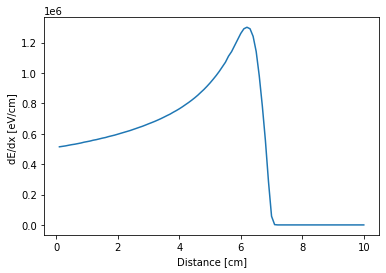

In [4]:
plt.plot(dEdx_data[0],dEdx)
plt.xlabel("Distance [cm]")
plt.ylabel("dE/dx [eV/cm] ")


# Simulate Po210 alpha tracks

This makes lines of ionization with the dEdx specified by SRIM. The tracks start at the cathode and travel downwards within a specified solid angle.

In [5]:
# The paramters, in order, are:
# number of simulations
# minimum angle to vertical [degrees] - this is based  on requiring a min. of 5 hits
# maximum angle to vertical [degrees]
# drfit length [cm]
# W-value as obtained using degrad for 70% He 30% CO2

def sim_p210(n_sims = 100, theta_min = theta_min, theta_max = theta_max, DL = 1.2, W = 35.2):

    tracks = pd.DataFrame(columns = ['init_dir', 'init_pos', 'track'])

    for i in range(n_sims):

        # draw a random direction within specified solid angle (pointing down towards the readout plane)
        v = random_three_vector(theta_min,theta_max)

        # Maximumm track length of alpha track
        L_max = -DL/v[2]

        # Length segments we will distribute charge on, 0.1 is the resolution of length of the SRIM simulation
        L_segments = np.arange(0,L_max+0.1,0.1)

        # Edges of the length segments we will distribute charge on (all edges are listed)
        L_edges = np.append(L_segments,L_max)

        # Energy deposited in each segment given dEdx (energy in each bin is listed)
        E_segments = dEdx[0:len(L_segments)]*np.diff(L_edges)

        # Compute corresponding number of ionizaed eletrons using energy deposited per segment divided by W-value
        Ne_segments = np.round(E_segments/W).astype("int")

        #find left and right edges for each bin
        Left_edges = L_segments[0:-1]
        Right_edges = L_segments[1:]

        track = np.empty((0,3))

        for N,left_edge,right_edge in zip(Ne_segments,Left_edges,Right_edges):

            Ts = np.random.uniform(low=left_edge,high=right_edge,size=N)

            x_vals = Ts*v[0]
            y_vals = Ts*v[1]
            z_vals = DL + Ts*v[2]

            Track_segment = np.array([x_vals,y_vals,z_vals]).T

            track = np.append(track,Track_segment,axis=0)

        x_rand = np.random.uniform()-0.5
        y_rand = np.random.uniform()-0.5

        track[:,0] = track[:,0]+x_rand # randomize x position (1 cm random uniform dist)
        track[:,1] = track[:,1]+y_rand # randomize y position (1 cm random uniform dist)

        tracks = tracks.append({'init_dir' : v, 'init_pos' : np.array([x_rand,y_rand,DL]), 'track' : track }, ignore_index = True)

    return tracks




In [6]:
# Example of track simulation
tracks = sim_p210(n_sims = 100)
tracks.head()

,init_dir,init_pos,track
0,"[0.3716483656798401, 0.09317006203644825, -0.9...","[0.04085606909413708, -0.37979836922663646, 1.2]","[[0.04500311768235613, -0.3787587285073083, 1...."
1,"[-0.26678235518519333, -0.16964694307969944, -...","[0.4055854059388032, 0.4314768987106229, 1.2]","[[0.382683427235022, 0.416913526725711, 1.1185..."
2,"[-0.4485274517406365, 0.04643686109539524, -0....","[-0.21073740073707392, -0.12414475932293934, 1.2]","[[-0.25504881619455005, -0.11955711806139836, ..."
3,"[-0.3241265192188449, -0.2942210568179352, -0....","[0.10050692552428864, 0.3252930484763933, 1.2]","[[0.07451842544949319, 0.3017023716766446, 1.1..."
4,"[-0.2714042345941379, -0.34357848854908607, -0...","[-0.4125093905384948, 0.21264427065905922, 1.2]","[[-0.4301309807376749, 0.19033658877812046, 1...."


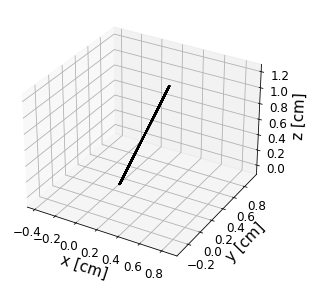

In [7]:
# Plot a Track
index = 1
track = tracks.iloc[index]["track"]
plot_track(track)

# Add diffusion to raw tracks

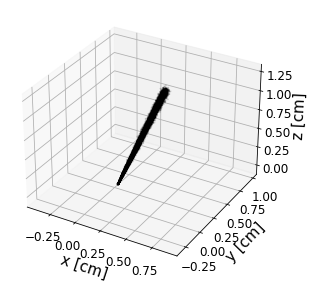

In [8]:
# The paramters, in order, are:
# tracks, a dataframe with the raw track info
# Transverse diffusion coefficent for 70% He 30% CO2 from Magboltz [cm/sqrt(cm)]
# Longitudinal diffusion coefficent for 70% He 30% CO2 from Magboltz [cm/sqrt(cm)]
tracks = xyStripTools.add_diff(tracks, DTrans = 0.0135, DLong = 0.0129)

# Plot a Track
index = 1
track = tracks.iloc[index]["diff_track"]
plot_track(track)

# Simulate readout


Simulates a 10 cm x 10 cm readout plane in the xy-plane centered at the origin

In [9]:
# the parameters, in order, are:
# peaking time [ns]
# digitization time [ns] 
# pitch of the x strips [um]
# pitch of the y strips [um]
# Threshold of x strips [No. electrons]
# Threshold of y strips [No. electrons]
# Charge sharing [lower strips / upper strips]
# Gain - extrapolating from PHA curve
# drift speed cm/ns
# Include charge integration effect.
# z resolution in cm, must be specified if Charge_integration = False
# Electronic gain in x [mV/fC]
# Electronic gain in y [mV/fC]
hits = xyStripTools.sim_readout(tracks, peaking_time = 200, digit_t  = 250, pitch_x = 200, pitch_y = 200,thres_x = 82/9.0*6241.5, thres_y =  82/4.5*6241.5, CS = 0.62, Gain = 604, v_drift = 0.0008, Charge_integration = True, DL = 1.2, pitch_z = 0.02, G_x = 9.0, G_y = 4.5)
tracks = pd.concat([tracks,hits],axis=1)
tracks.head()


,init_dir,init_pos,track,diff_track,strips_x,strips_y,times_x,times_y,electrons_x,electrons_y,adcs0,adcs1,strips0,strips1,times0,times1
0,"[0.3716483656798401, 0.09317006203644825, -0.9...","[0.04085606909413708, -0.37979836922663646, 1.2]","[[0.04500311768235613, -0.3787587285073083, 1....","[[0.054542929439812704, -0.3723875319534088, 1...","[0.04999999999989235, 0.06999999999989193, 0.0...","[-0.3700000000000987, -0.3500000000000991, -0....","[1437.975450932906, 1398.6212028192099, 1334.4...","[1425.2730811833953, 1141.3735054136596, 986.4...","[105409.18518518518, 157651.45679012343, 14886...","[340402.4691358025, 513772.8395061728, 433985....","[151.99594114662605, 227.3272628552609, 214.66...","[245.42355381096067, 370.4202159381203, 312.89...","[252, 253, 254, 255, 256, 257, 258, 259, 260, ...","[231, 232, 233, 234, 234, 235, 235, 236, 237]","[1437.975450932906, 1398.6212028192099, 1334.4...","[1425.2730811833953, 1141.3735054136596, 986.4..."
1,"[-0.26678235518519333, -0.16964694307969944, -...","[0.4055854059388032, 0.4314768987106229, 1.2]","[[0.382683427235022, 0.416913526725711, 1.1185...","[[0.37784033844041387, 0.420273888803412, 1.10...","[0.06999999999989193, 0.0899999999998915, 0.10...","[0.20999999999988894, 0.22999999999988852, 0.2...","[29.119805020603618, 99.7918320371862, 188.618...","[17.89336100252401, 96.1440546187017, 218.9500...","[165279.75308641975, 275080.98765432095, 26560...","[126392.59259259258, 676330.8641975308, 555158...","[238.32696912245098, 396.6560744835198, 382.98...","[91.12659884109054, 487.62138730896237, 400.25...","[253, 254, 255, 256, 257, 258, 259, 260, 261, ...","[260, 261, 262, 263, 264, 265, 266, 267, 268]","[29.119805020603618, 99.7918320371862, 188.618...","[17.89336100252401, 96.1440546187017, 218.9500..."
2,"[-0.4485274517406365, 0.04643686109539524, -0....","[-0.21073740073707392, -0.12414475932293934, 1.2]","[[-0.25504881619455005, -0.11955711806139836, ...","[[-0.2491063321433898, -0.11068803613973167, 1...","[-0.8100000000000893, -0.7900000000000897, -0....","[-0.1300000000001038, -0.11000000000010424, -0...","[18.23327012941559, 60.231843509626536, 109.86...","[1182.3207084621997, 967.6077151747957, 1401.9...","[118585.33333333331, 161581.18518518517, 16689...","[215501.2345679012, 494758.024691358, 363145.6...","[170.99543378995432, 232.99377820502548, 240.6...","[155.37219507418976, 356.7109046080447, 261.82...","[209, 210, 211, 212, 213, 214, 215, 216, 217, ...","[243, 244, 244, 245, 245, 245, 246, 246]","[18.23327012941559, 60.231843509626536, 109.86...","[1182.3207084621997, 967.6077151747957, 1401.9..."
3,"[-0.3241265192188449, -0.2942210568179352, -0....","[0.10050692552428864, 0.3252930484763933, 1.2]","[[0.07451842544949319, 0.3017023716766446, 1.1...","[[0.08189710790095668, 0.31117826090051304, 1....","[-0.33000000000009955, -0.3100000000001, -0.29...","[-0.07000000000010509, -0.050000000000105516, ...","[22.605890744981785, 78.40438723089547, 146.79...","[16.861334317516203, 67.331699572049, 144.4662...","[152797.0864197531, 231160.49382716048, 222145...","[164795.06172839506, 420562.9629629629, 397446...","[220.32744977614, 333.32443233909225, 320.3247...","[118.81403152732159, 303.217709418142, 286.551...","[233, 234, 235, 236, 237, 238, 239, 240, 241, ...","[246, 247, 248, 249, 250, 251, 252, 253, 254, ...","[22.605890744981785, 78.40438723089547, 146.79...","[16.861334317516203, 67.331699572049, 144.4662..."
4,"[-0.2714042345941379, -0.34357848854908607, -0...","[-0.4125093905384948, 0.21264427065905922, 1.2]","[[-0.4301309807376749, 0.19033658877812046, 1....","[[-0.44600079783577934, 0.19462781056800826, 1...","[-0.7700000000000902, -0.7500000000000906, -0....","[-0.25000000000010125, -0.23000000000010168, -...","[32.43222516556966, 105.8246122129872, 186.944...","[11.179873682647148, 54.81580457577886, 119.60...","[207119.8024691358, 272075.9012345679, 256125....","[115580.24691358024, 341893.8271604938, 343758...","[298.6586913758266, 392.32285686

# Perform 3D Reconstruction

[   5.74455643   61.54305291  129.93646934  200.15234287  269.66383468
  338.12292066  407.92222065  478.09011613  544.72041656  615.33565195
  680.08962989  749.46471159  810.83338707  884.30409632  953.3954564
 1024.90658203 1089.93488719 1153.57828843 1221.45783593 1290.79101008
 1360.24602299 1400.82107003]


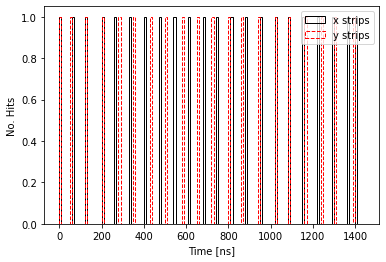

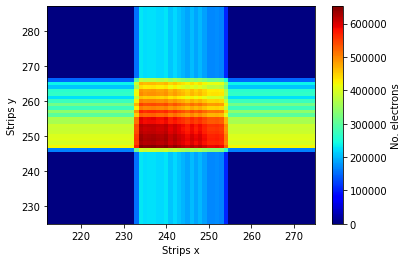

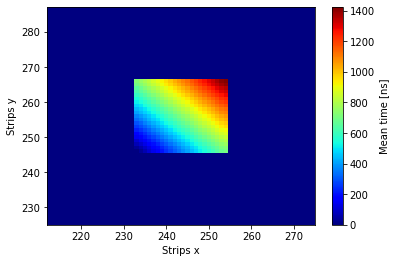

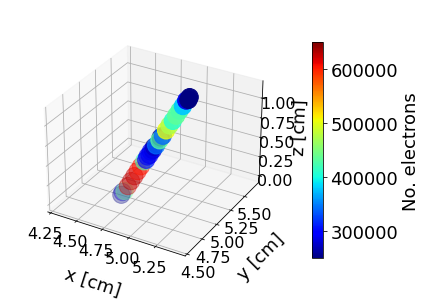

In [15]:
# 3D clustering paramters
# Obtained experimentally for the UH DLC detector quadrant a (see nimA paper)
mu = T_off.iloc[0]["Mu"]
sigma = T_off.iloc[0]["Sigma"]
n_sigma = 3

# Look at a single event after the cut
test_event = tracks.iloc[3]
# Make a TrackTools object for the event
dsp = xyStripTools.TrackTools(event = test_event, Mult_factor = 1.0, gain_x=9, gain_y=4.5, v_drift=8.0)

# Plot 1D time display
dsp.TimeHistView( t_bin =10)

# Plot 2D displays of charge and time
dsp.Strip2DView(fullview = False)
dsp.Strip2DView_times(fullview = False)

# Plot 3D displays
x,y,z,c = dsp.Reconst3D_v1( mu = mu, sigma = sigma , n_sigma = n_sigma)